# Semi-Supervised VAE Project
## By VAEGen

## Setup

### Import libraries

In [1]:
import os
import time
import torch
import argparse
from functools import reduce
# 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


# Torch
import torch
from torch.distributions import Bernoulli
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F

# Torchvision
import torchvision
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor

### Meta parameters

In [2]:
batch_size = 512
learning_rate = 1e-3
latent_dim = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print layers, used for debugging
NNprint_ = False
classes = [0,1,2,3,4,5,6,7,8,9]
num_classes=len(classes)

### Import MNIST Dataset

In [3]:
# transforms arrays into tensors, can be extended
transformations = transforms.Compose([
                          transforms.ToTensor(),
                          transforms.Lambda(lambda p: Bernoulli(probs=p).sample())])

# define the train and test sets
dset_train = MNIST(root='data', train=True,  transform=transformations, download=True)
dset_test  = MNIST(root='data', train=False, transform=transformations)

def stratified_sampler(labels,classes):
    """Sampler that only picks datapoints corresponding to the specified classes"""
    (indices,) = np.where(reduce(lambda x, y: x | y, [labels.numpy() == i for i in classes]))
    indices = torch.from_numpy(indices)
    return SubsetRandomSampler(indices)

### Configure loaders

In [4]:
def get_target_indexes(dset, classes, n_examples):
  """Get indexes for n_examples of class in classes from dataset

  The returned indexes may be used for subsetting a dataset, e.g.
  if we just want classes 0, 1 and 2 and 10 examples of each.
  """
  idxs = []
  ts = []
  n_samples = n_examples * len(classes)

  for j, x in enumerate(dset.targets):
    if (ts.count(x.numpy()) < n_examples) and (x.numpy() in classes):
      ts.append(x.numpy())
      idxs.append(j)

    if len(idxs) == n_samples:
      break

  return idxs

In [5]:
# The loaders perform the actual work
train_loader = DataLoader(dset_train, batch_size=batch_size,
                          sampler=stratified_sampler(dset_train.targets,classes))
test_loader  = DataLoader(dset_test, batch_size=batch_size, 
                          sampler=stratified_sampler(dset_test.targets,classes))

# subset training data
idx_train_subset = get_target_indexes(dset_train, classes, 100)
dset_train_subset = torch.utils.data.Subset(dset_train, idx_train_subset)

dset_train_subset_loader = torch.utils.data.DataLoader(
  dset_train_subset,
  batch_size=batch_size)

# subset test data
idx_test_subset = get_target_indexes(dset_test, classes, 100)
dset_test_subset = torch.utils.data.Subset(dset_test, idx_test_subset)

dset_test_subset_loader = torch.utils.data.DataLoader(
  dset_test_subset,
  batch_size=batch_size)

### Plot examples

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
image_channels = example_data.size(1)

def plot_examples(model=None,sample=False,data=None,y=torch.arange(len(classes)-1)):
    if data is None:
        if (model==None):
            batch_idx, (data, example_targets) = next(examples)
        else:
            if sample:
                data = model.sample(y=y)["xr"]
            else:
                data = model(data.to(device),example_targets)[0]
        
    fig = plt.figure()
    fig.set_figheight(15)
    fig.set_figwidth(15)
    for i in range(min(data.size(0),64)):
        plt.subplot(8,8,i+1)
        plt.tight_layout()
        if model:
            plt.imshow(data[i][0].cpu().data,  interpolation='none')
        else:
            plt.imshow(data[i][0], interpolation='none')
    #     plt.title("Ground Truth: {}".format(example_targets[i]))
        plt.xticks([])
        plt.yticks([])

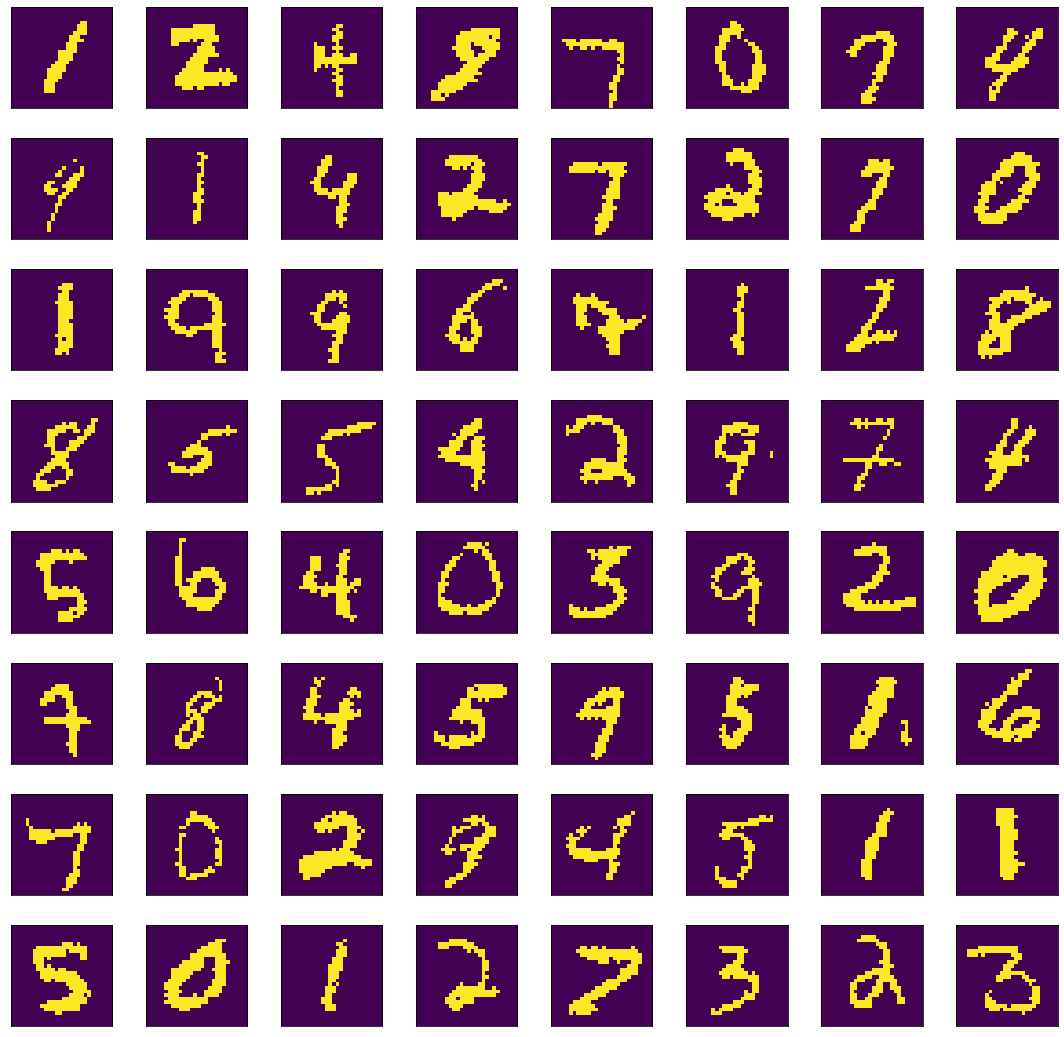

In [7]:
plot_examples()

### Torch auxiliary modules

In [8]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)
    
class UnFlatten(torch.nn.Module):
    def forward(self, input, size=1024):
        return input.view(input.size(0), size, 1, 1)

    
class UnFlatten_FF(torch.nn.Module):
    def forward(self, input, size=784):
        return input.view(-1,1,28,28)
   
# Debugging module 
class NNprint(torch.nn.Module):
    def forward(self, input):
        if NNprint_==True:
            print(input.shape)
        return input

def reduce_sum(x: torch.Tensor) -> torch.Tensor:
    """for each datapoint: sum over all dimensions"""
    return x.view(x.size(0), -1).sum(dim=1)

# Semi-supervised Convolutional CVAE

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


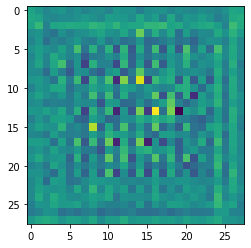

In [11]:
class M2(torch.nn.Module):
    def __init__(self, image_channels=1, h_dim=1024, z_dim=32, num_labels=0):
        super(M2, self).__init__()
        self.h_dim = h_dim
        self.z_dim = z_dim
        self.num_labels=num_labels

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(image_channels, 32, kernel_size=3, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Conv2d(32, 64, kernel_size=3, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout2d(p=.2),
            torch.nn.Conv2d(64, 128, kernel_size=3, stride=1),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout2d(p=.2),
            torch.nn.Conv2d(128, 256, kernel_size=3, stride=1),
            torch.nn.LeakyReLU(),
            Flatten(),
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.LeakyReLU()
        )

        self.mu = torch.nn.Linear(h_dim + num_labels, z_dim) # mean 
        self.logsigma = torch.nn.Linear(h_dim + num_labels, z_dim) # standard deviation
        self.upscale_z = torch.nn.Linear(z_dim+num_labels, h_dim)


        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(h_dim,h_dim),
            torch.nn.LeakyReLU(),
            UnFlatten(),
            torch.nn.ConvTranspose2d(h_dim, 128, kernel_size=4, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout2d(p=.2),
            torch.nn.ConvTranspose2d(128, 64, kernel_size=5, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.Dropout2d(p=.2),
            torch.nn.ConvTranspose2d(
                64, 32, kernel_size=4, padding=0, stride=2),
            torch.nn.LeakyReLU(),
            torch.nn.ConvTranspose2d(
                32, image_channels, kernel_size=5, stride=1),
            torch.nn.Sigmoid()
        )

        # simple FFNN classifier
        # input: flattened vector, output: probability of each class
        # TODO: implement CNN classifier
        self.classifier = torch.nn.Sequential(
            Flatten(),
            torch.nn.Linear(784, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 256),
            torch.nn.ReLU(),
            torch.nn.Linear(256, self.num_labels), # 3 output layer
            torch.nn.Softmax(dim=1)
        )
        
    def reparameterize(self, mu, logvar):
        std = logvar.exp()
        eps = torch.randn(*mu.size())
        z = mu.to(device) + std.to(device) * eps.to(device)
        return z

    def encode(self, x, y):
        # pass x through conv encoder and flatten output to obtain h
        # n.b. normally [x,y] would be encoded, but this is not possible with a
        # CNN architecture
        h = self.encoder(x)

        # concat y (labels) to h, to place in latent space
        h = torch.cat((h, torch.nn.functional.one_hot(y, self.num_labels).type(torch.float).to(device)), 1)

        # fc1 encodes [h,y] into mu; fc2 encodes [h,y] into logvar
        mu, logvar = self.mu(h), self.logsigma(h) # use relu to prevent negative values
        
        return mu, logvar

    def decode(self, z, y):
        # concat y (labels) to z_lab, to place in latent space
        z_y = torch.cat((z, torch.nn.functional.one_hot(y, self.num_labels).type(torch.float).to(device)), 1)
        
        # upscale [z,y] to h_dim
        h = self.upscale_z(z_y)

        # decode upscaled [z,y] to x_recon
        x_recon = self.decoder(h)
        return x_recon
    
    def forward(self, x_labelled, x_unlabelled, y):
        # labeled case ########################################################
        # encode [x_labelled,y] to mu_lab and logvar_lab
        mu_lab, logvar_lab = self.encode(x_labelled, y)
        
        # sample z_lab using mu_lab and logvar_lab
        z_lab = self.reparameterize(mu_lab, logvar_lab)

        # decode [z_lab,y] to get reconstruction
        x_lab_recon = self.decode(z_lab, y)


        # classification ######################################################
        # labelled case - this is used for the classification objective loss
        y_labelled_pred = self.classifier(x_labelled)

        # unlabelled case - predict a y for the entropy term, H(q(y|x))
        y_unlabelled_pred = self.classifier(x_unlabelled)

        # unlabeled case ######################################################
        # integrate over y -- i.e. perform generation and inference for any 
        # possible class of y. Then calculate loss for any case
        # We do this by tiling x_unlabelled and y, then concat for parallelism

        # TODO: repeat copies the data, so there might be a less expensive way to do this
        x_unlab_tiled = x_unlabelled.repeat(self.num_labels,1,1,1)
        # tensor of class labels [0,1,2,3,4,5,6,7,8,9], repeated for number of datapoints as [0_0,0_1,0_n, ...]
        y_unlab_tiled = torch.repeat_interleave(torch.arange(self.num_labels), x_unlabelled.shape[0])

        # encode x_unlab and y_unlab to mu_unlab and logvar_unlab
        mu_unlab, logvar_unlab = self.encode(x_unlab_tiled, y_unlab_tiled)

        # sample z_unlab via mu_unlab and logvar_unlab
        z_unlab = self.reparameterize(mu_unlab, logvar_unlab)

        # decode [z_unlab,y_unlab] to get reconstruction
        x_unlab_recon = self.decode(z_unlab, y_unlab_tiled)

        # TODO: Find better solution
        return {'L' : (mu_lab, logvar_lab, z_lab, x_lab_recon, y_labelled_pred), \
                'U' : (mu_unlab, logvar_unlab, z_unlab, x_unlab_recon, y_unlabelled_pred)}
    
    def log_prob_gaussian(self, x, mu, log_sigma):
      eps = 1e-10
      sigma = log_sigma.exp()
      logprob = -torch.log(sigma * np.sqrt(2*np.pi) + eps) - 0.5 * ((x - mu)/sigma)**2
      return logprob

    def Lb(self, x, x_recon, yp, z, mu, logvar):
      """Calculate lower bound, -L(x,y)

      -L(x,y) is used to calculate loss for both the Labelled and Unlabelled case

      Formula:
        -L(x,y) = E_q(z|x,y) [ logp(x|y,z) + logp(y) + logp(z) - logq(z|x,y) ]

      Returns
        Lower bound. Should return negative value.
        For loss: change sign (so loss is positive) and take mean of batch to minimize
      """
      logpx = -F.binary_cross_entropy(x_recon, x.to(device), size_average=False, reduce=False) # negate or not?
      logpx = reduce_sum(logpx) # sum loss per datapoint, but not over batch
      logpy = torch.log(yp) # natural log, ln
      logpz = reduce_sum(self.log_prob_gaussian(z, torch.zeros_like(z), torch.ones_like(z))) # logprob Gaussian for z, 0, I # suspect
      logqz = reduce_sum(self.log_prob_gaussian(z, mu, logvar)) # logprob Gaussian for z, mu, logvar
      lower_bound = logpx + logpy + logpz - logqz
      return lower_bound # N.B. we don't take the mean here!

    def H(self, p):
      """Calculate Entropy, H(p)
      Where
        H(p) = -∑p(i) * log(p(i))
      """
      eps = 1e-10
      return -torch.sum((p * torch.log(p + eps)), dim=1)

    def J_alpha(self, x_labelled, y_labelled, x_unlabelled, Ls, Us, alpha=.1):
      """Calculate loss as J_alpha

      J_alpha = J + alpha * C

      Where
        J = ∑L(x,y) + ∑U(x)
        -L(x,y) = E_q(z|x,y)[logp(x|y,z) + logp(y) + logp(z) - logq(z|x,y)]
        -U(x) = ∑_y q(y|x)(-L(x,y)) + H(q(y|x))
        C = E_p(x,y) [-logq(y|x)]
      """
      # labelled loss ##########################################################
      mu, logvar = Ls[0], Ls[1]
      z = Ls[2]
      x_recon = Ls[3]
      # y_prob is just a uniform dist over the labels, i.e. 1/n prob per class
      y_prob = torch.Tensor([(1/self.num_labels)]).to(device)

      # -L(x,y), note the sign
      Lxy = self.Lb(x_labelled, x_recon, y_prob, z, mu, logvar) # (10,), when using 10% labelled data
      
      # unlabelled loss ########################################################
      mu, logvar = Us[0], Us[1]
      z = Us[2]
      x_recon = Us[3]
      # y_prob is just a uniform dist over the labels, i.e. 1/n prob per class
      y_prob = torch.Tensor([(1/self.num_labels)]).to(device)
      
      # use list comprehension to get probabilities for class i for an entire batch
      # i.e. first probs for class == 0, then class == 1, etc.
      # y_pred_tiled = torch.cat([y_pred[:,i] for i in range(self.num_labels)])

      # integrate over y
      y_pred = Us[4]
      tiled_size = x_recon.shape[0]
      batch_size = y_pred.shape[0]
      n_classes = int(tiled_size/batch_size)
      U = torch.zeros(batch_size).to(device) # (90,), # when using 90% labelled data
      # iterate over tiles, i.e. ∑y q(y|x)(-L(x,y))
      for i in range(n_classes):
        # indexes for slicing
        l = i*y_pred.shape[0]
        r = l+y_pred.shape[0]
        # y_slice, i.e. y_pred should be shape (batch,n_classes)
        y_slice = y_pred[:,i] # probabilities for class i for whole batch (batch,) = (90,)
        # -L(x,y), note the sign
        Luxy = self.Lb(x_unlabelled, x_recon[l:r,:], y_prob, z[l:r], mu[l:r,:], logvar[l:r,:]) # (batch,) = (90,)
        U += (y_slice * Luxy) # (batch,) = (90,)
      
      # add entropy H to each datapoint (which is summed over y's in loop above)
      H = self.H(y_pred) # (batch,) = (90,)
      U = U + H # no mean yet, because we are still doing computing per datapoint
      
      # classification loss ####################################################
      y = y_labelled
      y_labelled_pred = Ls[4]
      C = F.cross_entropy(y_labelled_pred, y, reduce=False)
      
      # final loss #############################################################
      J = -Lxy.mean() + -U.mean()
      Ja = J + alpha * C.mean()
      return Ja


    def sample(self, y: torch.Tensor()):
        """Sample z, conditioning on y and reconstruct

        y : torch.int64
        """
        batch_size = y.size(0)

        # sample z ~ N(0,I)
        mu, logvar = torch.zeros((batch_size, self.z_dim)), torch.ones(
            batch_size, self.z_dim)
        
        z = self.reparameterize(mu, logvar)

        # decode sampled z with condition
        x_recon = self.decode(z, y)
        return {"xr" : x_recon.detach(), "z" : z.detach()} # no gradient_fn

# test model
model = M2(image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
# print("Model\n", model)

# test forward-pass
split_by = int(batch_size/10)
x_l = example_data[:split_by].to(device)
y_l = example_targets[:split_by].to(device)
x_u = example_data[split_by:].to(device)
out_fpass = model(x_l, x_u, y_l)

# test loss
loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
# print("Loss (should be positive, so we can minimize it)\n", loss)

# test sample
x_recon = model.sample(y=torch.arange(len(classes)-1))["xr"]

plt.imshow(x_recon[0][0].cpu(), interpolation='none')

In [12]:
def fit_model(model, train_loader):
    model.train()
    running_loss = 0.0
    running_acc = 0.0
    
    # Run each batch in training dataset
    for idx, (images, labels) in enumerate(train_loader):
        # split in labelled / unlabelled
        x_u, x_l = train_test_split(images, test_size=0.1, shuffle=True, random_state=42)
        x_u, x_l = x_u.to(device), x_l.to(device)
        y_u, y_l = train_test_split(labels, test_size=0.1, shuffle=True, random_state=42)
        y_u, y_l = y_u.to(device), y_l.to(device)
        
        out_fpass = model(x_l, x_u, y_l)
        
        y_pred = out_fpass["L"][4].detach().cpu().numpy()
        y_pred = np.argmax(y_pred, axis=1)
        acc = accuracy_score(y_l.cpu().numpy(), y_pred)
        loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss
        running_acc += acc
    
    loss_mean = running_loss/len(train_loader)
    acc_mean = running_acc/len(train_loader)
    return loss_mean, acc_mean
    

def test_model(model, test_loader):
    model.eval()
    running_loss = 0.0
    running_acc = 0.0

    with torch.no_grad():
        for idx, (images, labels) in enumerate(test_loader):
            # split in labelled / unlabelled
            x_u, x_l = train_test_split(images, test_size=0.1, shuffle=True, random_state=42)
            x_u, x_l = x_u.to(device), x_l.to(device)
            y_u, y_l = train_test_split(labels, test_size=0.1, shuffle=True, random_state=42)
            y_u, y_l = y_u.to(device), y_l.to(device)

            out_fpass = model(x_l, x_u, y_l)

            y_pred = out_fpass["L"][4].detach().cpu().numpy()
            y_pred = np.argmax(y_pred, axis=1)
            acc = accuracy_score(y_l.cpu().numpy(), y_pred)
            
            loss = model.J_alpha(x_l, y_l, x_u, out_fpass['L'], out_fpass['U'])
            
            running_loss += loss
            running_acc += acc

    loss_mean = running_loss/len(test_loader)
    acc_mean = running_acc/len(test_loader)
    return loss_mean, acc_mean

In [13]:
model = M2(image_channels=image_channels, h_dim=1024, z_dim=latent_dim, num_labels=num_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [14]:
train_loss = []
train_acc = []
test_loss = []
test_acc = []

In [15]:
epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    
    print("\t Training ...")
    train_epoch_loss, train_epoch_acc = fit_model(model, train_loader)
    
    print("\t Testing ...")
    test_epoch_loss, test_epoch_acc = test_model(model, test_loader)
    train_loss.append(train_epoch_loss)
    train_acc.append(train_epoch_acc)
    test_loss.append(test_epoch_loss)
    test_acc.append(test_epoch_acc)

    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {test_epoch_loss:.4f}")
    print(f"Train Acc: {train_epoch_acc:.4f}")
    print(f"Val Acc: {test_epoch_acc:.4f}")

# torch.save(model.state_dict(), 'cvae.torch')

Epoch 1 of 10
	 Training ...


/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


	 Testing ...
Train Loss: 449.8426
Val Loss: 375.4024
Train Acc: 0.2643
Val Acc: 0.4795
Epoch 2 of 10
	 Training ...
	 Testing ...
Train Loss: 350.3683
Val Loss: 311.0074
Train Acc: 0.6756
Val Acc: 0.8331
Epoch 3 of 10
	 Training ...
	 Testing ...
Train Loss: 303.4516
Val Loss: 289.3575
Train Acc: 0.8331
Val Acc: 0.8582
Epoch 4 of 10
	 Training ...
	 Testing ...
Train Loss: 291.4556
Val Loss: 281.8070
Train Acc: 0.8810
Val Acc: 0.8694
Epoch 5 of 10
	 Training ...
	 Testing ...
Train Loss: 281.5740
Val Loss: 269.3993
Train Acc: 0.8963
Val Acc: 0.9089
Epoch 6 of 10
	 Training ...
	 Testing ...
Train Loss: 272.3303
Val Loss: 263.0251
Train Acc: 0.9061
Val Acc: 0.9158
Epoch 7 of 10
	 Training ...
	 Testing ...
Train Loss: 269.7002
Val Loss: 260.6643
Train Acc: 0.9239
Val Acc: 0.9214
Epoch 8 of 10
	 Training ...
	 Testing ...
Train Loss: 264.8999
Val Loss: 257.0993
Train Acc: 0.9265
Val Acc: 0.9332
Epoch 9 of 10
	 Training ...
	 Testing ...
Train Loss: 258.9991
Val Loss: 248.3837
Train Acc:

In [16]:
torch.save(model.state_dict(), 'M2_201210_0940.torch')

(Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Acc'))

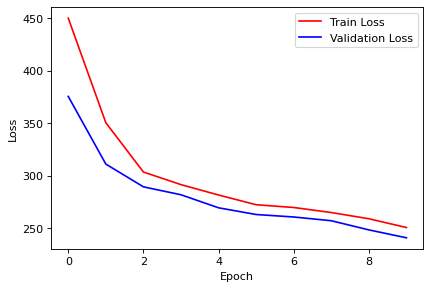

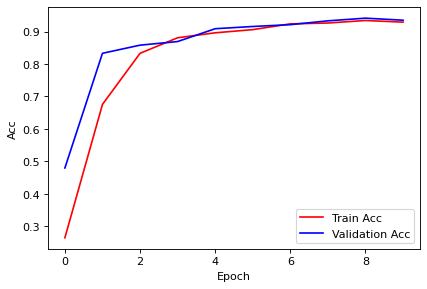

In [17]:
x_epoch = np.arange(len(train_loss))
plt.figure(dpi=80, facecolor='w', edgecolor='k')
plt.plot(x_epoch, train_loss, 'r', x_epoch, test_loss, 'b')
plt.legend(['Train Loss', 'Validation Loss'])
plt.xlabel('Epoch'), plt.ylabel('Loss')

x_epoch = np.arange(len(train_acc))
plt.figure(dpi=80, facecolor='w', edgecolor='k')
plt.plot(x_epoch, train_acc, 'r', x_epoch, test_acc, 'b')
plt.legend(['Train Acc', 'Validation Acc'])
plt.xlabel('Epoch'), plt.ylabel('Acc')

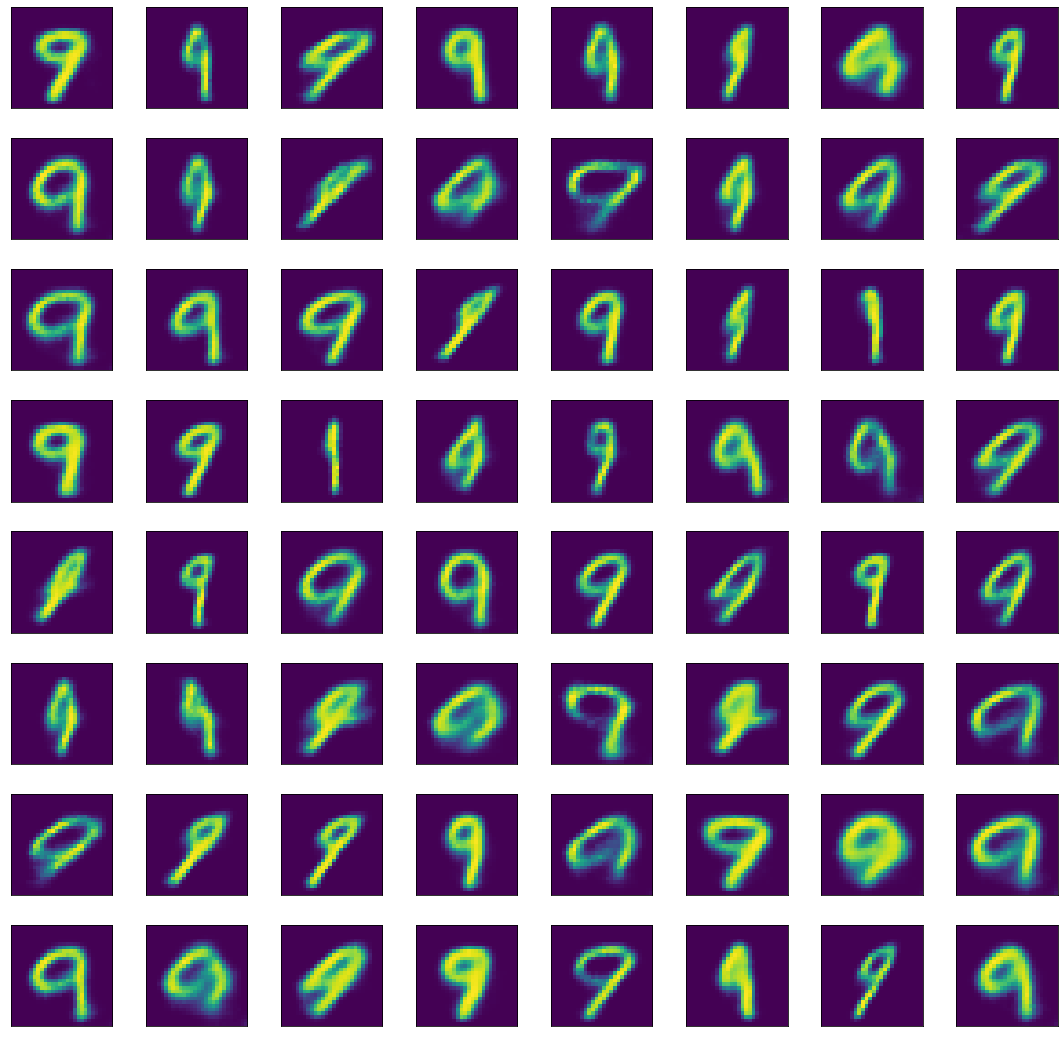

In [24]:
# plot_examples(model, sample=True, y=torch.zeros(64).type(torch.int64))
# plot_examples(model, sample=True, y=(torch.ones(64).type(torch.int64)*1))
# plot_examples(model, sample=True, y=(torch.ones(64).type(torch.int64)*2))
# plot_examples(model, sample=True, y=(torch.ones(64).type(torch.int64)*3))
plot_examples(model, sample=True, y=(torch.ones(64).type(torch.int64)*9))

# Plot confusion matrix

In [19]:
def make_cm(dset):
  idx_test_subset = get_target_indexes(dset, classes, 10)
  X_test = dset.data[idx_test_subset].type(torch.float)
  y_test = dset.targets[idx_test_subset].numpy()

  model.eval()
  with torch.no_grad():
      y_pred = model.classifier(X_test.to(device)).cpu().numpy()
      y_pred = np.argmax(y_pred, axis=1)

  cm = sklearn.metrics.confusion_matrix(y_true = y_test, y_pred = y_pred)
  df_cm = pd.DataFrame(cm, index = [str(i) for i in classes],
                        columns = [str(i) for i in classes])
  plt.figure(figsize = (10,7))
  sns.heatmap(df_cm, annot=True)

Mean acc (train):  0.9292046936114735
Mean acc (val):  0.9351648351648351


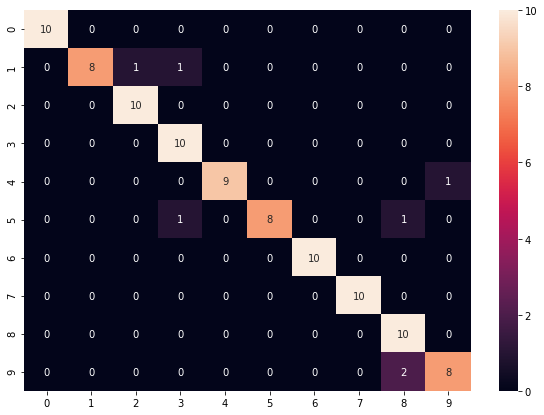

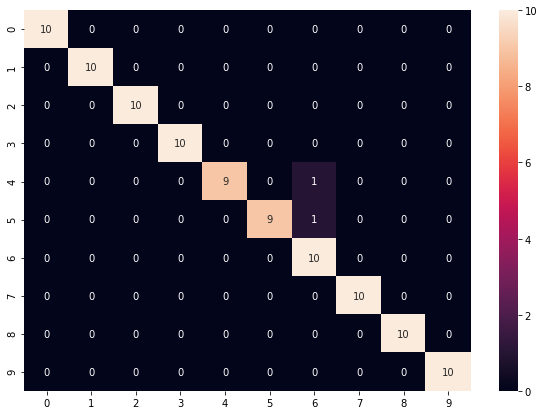

In [20]:
# MNIST
dset_name = str((dset_train.__class__)).split('.')[-1]
if (dset_name == "MNIST"):
  # get this from loop above
  print("Mean acc (train): ", train_acc[-1])
  make_cm(dset_train)

  print("Mean acc (val): ", test_acc[-1])
  make_cm(dset_test)

In [21]:
# FashionMNIST
dset_name = str((dset_train.__class__)).split('.')[-1]
if (dset_name == "FashionMNIST"):
  # get this from loop above
  print("Mean acc (train): ", train_acc[-1])
  make_cm(dset_train)

  print("Mean acc (val): ", test_acc[-1])
  make_cm(dset_test)

# Interpolations

In [80]:
z_in = model.sample(y=torch.Tensor([0,1,2,3,4,5,6,7,8,9]).type(torch.int64))["z"]

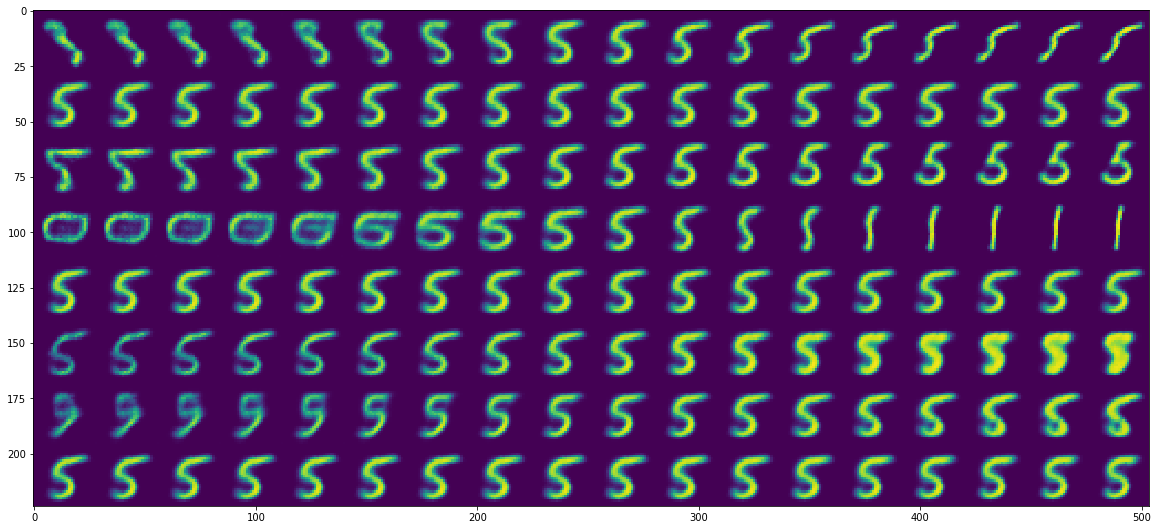

In [83]:
#torch.repeat_interleave(torch.arange(9), 18)
def plot_interpolation(z_in=None,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=20,std_=3,batch_size=100):
  if z_in is None:
      ztest =model.sample(batch_size=batch_size,z_out=True)
  else:
    ztest=z_in
  test_data=torch.zeros(latent_dim*interpolate_dim,latent_dim)
  for i in range(test_data.shape[0]):
      test_data[i]=ztest[image_n]
  range_=np.zeros([latent_dim,interpolate_dim])
  for c,i in enumerate(ztest.std(0).cpu().detach().numpy()):
      range_[c]=np.linspace(-std_*i,std_*i,int(interpolate_dim))
  for c in range(latent_dim*interpolate_dim):
      test_data[c][int(c/interpolate_dim)]=range_[int(c/interpolate_dim)][c%interpolate_dim]
      # print(c,int(c/interpolate_dim),"_",int(c/interpolate_dim),c%interpolate_dim,"_",range_[int(c/interpolate_dim)][c%interpolate_dim])
      # print(c,test_data[c].cpu().detach().numpy())
  smple_pic =model.decode(test_data.to(device),y=torch.ones(144).type(torch.int64)*5)
  all_pics=np.zeros([imsize*latent_dim,imsize*interpolate_dim])
  for i in range(latent_dim):
      for j in range(interpolate_dim):
  #         print(i,j)
          all_pics[i*imsize:(i+1)*imsize,j*imsize:(j+1)*imsize]=smple_pic[(interpolate_dim*i)+j][0].cpu().data
  fig = plt.figure()
  fig.set_figheight(40)
  fig.set_figwidth(20)
  plt.imshow(all_pics, interpolation='none')
  return(ztest.std(0).cpu().detach().numpy())
std__=plot_interpolation(z_in=z_in,image_n=0,latent_dim=latent_dim,imsize=28,interpolate_dim=18,std_=5,batch_size=10000)

In [ ]:
# MNIST


In [ ]:
# FashionMNIST
